# 实验准备

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rouge_score
!pip install pycocoevalcap

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=2c1cbc59dc549a89f5bdeb1f5b45011a0ff072c6fd32bb32d86e86f8151fb70c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 5.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BartForConditionalGeneration, BartTokenizer

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider

In [ ]:
# 如果计算机安装有CUDA，则使用CUDA进行接下来的全部训练，否则使用CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [ ]:
class DiagnosisDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        description = self.data.iloc[index]['description']
        diagnosis = self.data.iloc[index]['diagnosis']

        return description, diagnosis

folder_path = '/content/drive/MyDrive/Colab Notebooks/exp4'
train_set_path = folder_path + '/data/train.csv'
test_set_path = folder_path + '/data/test.csv'

# 读取训练数据
train_df = pd.read_csv(train_set_path, index_col=0)

# 将训练数据划分为训练集和验证集，固定划分（8:2）
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# 读取测试数据，即测试集
test_df = pd.read_csv(test_set_path, index_col=0)

print('X_train: ', train_df.shape)
print('X_val: ', val_df.shape)
print('X_test: ', test_df.shape)

train_dataset = DiagnosisDataset(train_df)
val_dataset = DiagnosisDataset(val_df)
test_dataset = DiagnosisDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

X_train:  (14400, 2)
X_val:  (3600, 2)
X_test:  (2000, 2)


# 训练并评价模型

In [ ]:
# 计算BLEU-4指标
def calculate_bleu_4(generated, reference):
    # 4-gram权重
    weights = [0.25, 0.25, 0.25, 0.25]

    # 使用加一平滑
    smoothing_function = SmoothingFunction().method1

    score = sentence_bleu([reference], generated, weights=weights, smoothing_function=smoothing_function)
    return score


# 计算ROUGE-2指标
def calculate_rouge_2(generated, reference):
    scorer = rouge_scorer.RougeScorer(['rouge2'])
    scores = scorer.score(' '.join(generated), ' '.join(reference))
    score = scores['rouge2'][0]
    return score


# 计算CIDEr指标
def calculate_cider(generated, reference):
    cider_scorer = Cider()
    score, _ = cider_scorer.compute_score(gts={0: [' '.join(reference)]}, res={0: [' '.join(generated)]})
    return score

In [ ]:
# 训练模型
def train_model(model, tokenizer, optimizer, epochs):
    model.to(device)

    train_loss = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for input_seq, target_seq in train_loader:
            # 将待更新参数的梯度置为零
            optimizer.zero_grad()

            input_encoded = tokenizer.batch_encode_plus(list(input_seq), padding=True, return_tensors='pt').to(device)
            target_encoded = tokenizer.batch_encode_plus(list(target_seq), padding=True, return_tensors='pt').to(device)

            output = model(input_ids=input_encoded["input_ids"], attention_mask=input_encoded["attention_mask"], labels=target_encoded["input_ids"])

            loss = output.loss

            # 反向传播，计算梯度
            loss.backward()

            # 利用梯度更新参数
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch: {epoch + 1}/{epochs}')
        print(f'Train Loss: {avg_loss}')
        train_loss.append(avg_loss)

    return model, train_loss

In [ ]:
# 评价模型
def evaluate_model(model, tokenizer, loader):
    model.to(device)
    model.eval()

    sum_bleu4 = 0
    sum_rouge2 = 0

    with torch.no_grad():
        for input_seq, target_seq in loader:
            input_encoded = tokenizer.batch_encode_plus(list(input_seq), padding=True, return_tensors='pt').to(device)

            output_ids = model.generate(input_ids=input_encoded["input_ids"], attention_mask=input_encoded["attention_mask"],max_length=20, num_beams=4, length_penalty=2.0, no_repeat_ngram_size=3)

            outputs = []
            for i in range(len(output_ids)):
                output = tokenizer.decode(output_ids[i], skip_special_tokens=True)
                outputs.append(output)

            bleu4 = 0
            rouge_2 = 0

            for i in range(len(target_seq)):
                output_valid = outputs[i].split()
                target_seq_valid = target_seq[i].split()
                bleu4 += calculate_bleu_4(output_valid, target_seq_valid)
                rouge_2 += calculate_rouge_2(output_valid, target_seq_valid)

            sum_bleu4 += bleu4
            sum_rouge2 += rouge_2

    avg_bleu4 = sum_bleu4 / len(loader)
    avg_rouge2 = sum_rouge2 / len(loader)

    print('BLEU-4: ', avg_bleu4)
    print('ROUGE-2: ', avg_rouge2)

    return avg_bleu4, avg_rouge2

In [ ]:
# 加载BART模型和分词器
model_name = 'facebook/bart-base'
model_path = folder_path + '/model/models--facebook--bart-base/snapshots/aadd2ab0ae0c8268c7c9693540e9904811f36177'
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path)

In [ ]:
learning_rate = 1e-4

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model, train_loss = train_model(model, tokenizer, optimizer, epochs=15)
print('Validation:')
val_bleu4, val_rouge2 = evaluate_model(model, tokenizer, val_loader)
print('Test:')
test_bleu4, test_rouge2 = evaluate_model(model, tokenizer, test_loader)

Epoch: 1/15
Train Loss: 1.5478282442357805
Epoch: 2/15
Train Loss: 0.8261300155851576
Epoch: 3/15
Train Loss: 0.7453406517373191
Epoch: 4/15
Train Loss: 0.7039316068092982
Epoch: 5/15
Train Loss: 0.6627774135271708
Epoch: 6/15
Train Loss: 0.634591862294409
Epoch: 7/15
Train Loss: 0.6173603374428219
Epoch: 8/15
Train Loss: 0.589740817281935
Epoch: 9/15
Train Loss: 0.566215555800332
Epoch: 10/15
Train Loss: 0.5470928762356441
Epoch: 11/15
Train Loss: 0.5250701816214456
Epoch: 12/15
Train Loss: 0.49729294684198166
Epoch: 13/15
Train Loss: 0.47927301353878443
Epoch: 14/15
Train Loss: 0.4485736052195231
Epoch: 15/15
Train Loss: 0.42578270071082647
Validation:
BLEU-4:  7.692383029592882
ROUGE-2:  10.921829398098357
Test:
BLEU-4:  7.969509482823933
ROUGE-2:  11.14315382054427


In [ ]:
# best: learning_rate = 1e-4, epochs = 10
print('Validation:')
print("BLEU-4: ", val_bleu4)
print("ROUGE-2: ", val_rouge2)
print('Test:')
print("BLEU-4: ", test_bleu4)
print("ROUGE-2: ", test_rouge2)

Validation:
BLEU-4:  7.844874289948872
ROUGE-2:  11.135870606309311
CIDEr:  0.0
Test:
BLEU-4:  8.127961046142788
ROUGE-2:  11.34432920509659
CIDEr:  0.0


# 绘制图像

In [ ]:
import matplotlib.pyplot as plt

# 绘制训练损失变化图
def plot_train_loss(train_loss, path):
    epoch = np.arange(1, 11)

    plt.plot(epoch, train_loss)

    plt.legend()
    plt.title('Train Loss for BART')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.savefig(path)

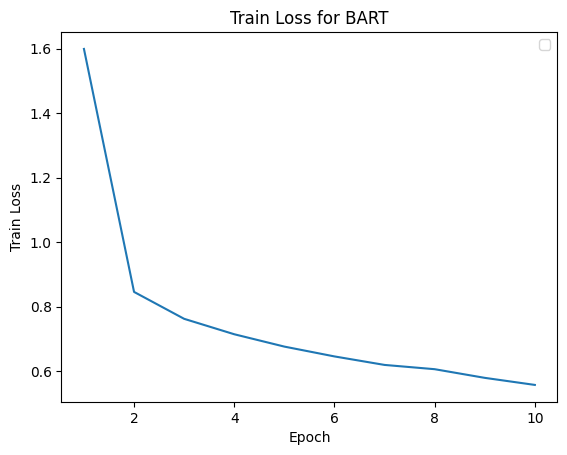

In [ ]:
fig_path = folder_path + '/graph/Train Loss for BART.png'
plot_train_loss(train_loss, fig_path)